<a href="https://colab.research.google.com/github/ArjunChakrawal/test_binder/blob/main/direct_ipopt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imports are adapted from [ND-Pyomo-Cookbook](https://jckantor.github.io/ND-Pyomo-Cookbook/06.04-Soft-Landing-Apollo-11-on-the-Moon.html)

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
from pyomo.environ import *
from pyomo.dae import *


     |████████████████████████████████| 9.7 MB 7.6 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 


In [ ]:
plt.style.use("ggplot")
from scipy import integrate

def optimal_growth(emax=0.5, beta=0.5, r=0.1, mu=0.5):
    t_f = 1
    m = ConcreteModel()
    m.t = ContinuousSet(bounds=(0, t_f))
    m.C = Var(m.t, bounds=(0, 1))

    m.u = Var(m.t, bounds=(0, 2))
    m.T = Var(domain=NonNegativeReals, bounds=(0, 100))

    def G(u): return beta*emax*((u-r)/(u+beta))

    m.dCdt = DerivativeVar(m.C, wrt=m.t)

    m.ode1 = Constraint(m.t, rule=lambda m, t:
                        m.dCdt[t]/m.T == -m.u[t] - gamma*m.C[t] + mu*G(m.u[t]))

    m.C[0].fix(1)
    # m.C[t_f].fix(0)
    # m.u[t_f].fix(0)

    m.J = Integral(m.t, wrt=m.t, rule=lambda m, t:  m.T*G(m.u[t]))
    m.obj = Objective(expr=m.J, sense=maximize)
    #
    TransformationFactory('dae.finite_difference').apply_to(
        m, nfe=1000, scheme='BACKWARD')

    # discretizer = TransformationFactory('dae.collocation')
    # discretizer.apply_to(m,nfe=500,scheme='LAGRANGE-RADAU',ncp=3)
    # force piecewise constant controls (acceleration) over each finite element
    # m1 = discretizer.reduce_collocation_points(m,var=m.u,ncp=1,contset=m.t)

    solver = SolverFactory('ipopt')
    solver.solve(m, tee=False)
    return m



terminal time = 1.5209508615519385


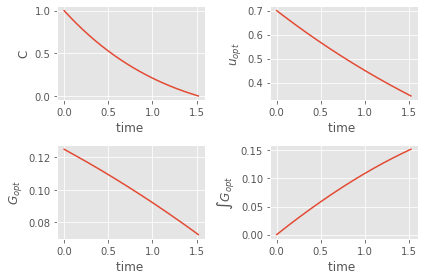

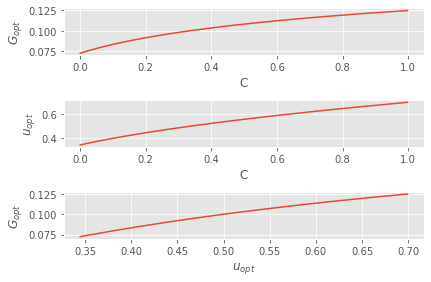

In [ ]:
gamma = 0.5
beta = 0.5
emax = 0.5
r = 0.1
mu = 0.5
m = optimal_growth(emax, beta, r, mu)
print("terminal time = " + str(m.T()))

tsim = np.array([t*m.T() for t in m.t])
x1sim = np.array([m.C[t]() for t in m.t])
usim = np.array([m.u[t]() for t in m.t])
gsim = np.array([beta*emax*((m.u[t]()-r)/(m.u[t]()+beta)) for t in m.t])
y_int = integrate.cumulative_trapezoid(gsim, tsim, initial=0)

tsim = tsim[1:-1]
x1sim = x1sim[1:-1]
usim = usim[1:-1]
gsim = gsim[1:-1]
y_int = y_int[1:-1]


plt.figure()
plt.subplot(2, 2, 1)
plt.plot(tsim, x1sim)
plt.xlabel('time ')
plt.ylabel('C')
plt.subplot(2, 2, 2)
plt.plot(tsim, usim, '-')
plt.xlabel('time ')
plt.ylabel(r'$u_{opt}$')
plt.subplot(2, 2, 3)
plt.plot(tsim, gsim, '-')
plt.xlabel('time ')
plt.ylabel(r'$G_{opt}$')
plt.subplot(2, 2, 4)
plt.plot(tsim, y_int, '-')
plt.xlabel('time ')
plt.ylabel(r'$\int G_{opt}$')
plt.tight_layout()
plt.savefig('Fig1.png', dpi=100)

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(x1sim, gsim, '-')
plt.xlabel('C')
plt.ylabel(r'$G_{opt}$')
plt.subplot(3, 1, 2)
plt.plot(x1sim, usim, '-')
plt.xlabel('C')
plt.ylabel(r'$u_{opt}$')
plt.subplot(3, 1, 3)
plt.plot(usim, gsim, '-')
plt.xlabel(r'$u_{opt}$')
plt.ylabel(r'$G_{opt}$')
plt.tight_layout()
plt.savefig('Fig2.png', dpi=100)